

# $\color{green}{\text{ 10. Non-negative matrix factorization }}$

- In non-negative matrix factorization, we are trying to factorise (separate) the **rating matrix** into **two matrices**, for **users** and for **films** separately, each of which also has **latent features** in the hidden axis. The sub-matrices are found so that **their product approximates ratings matrix R**.


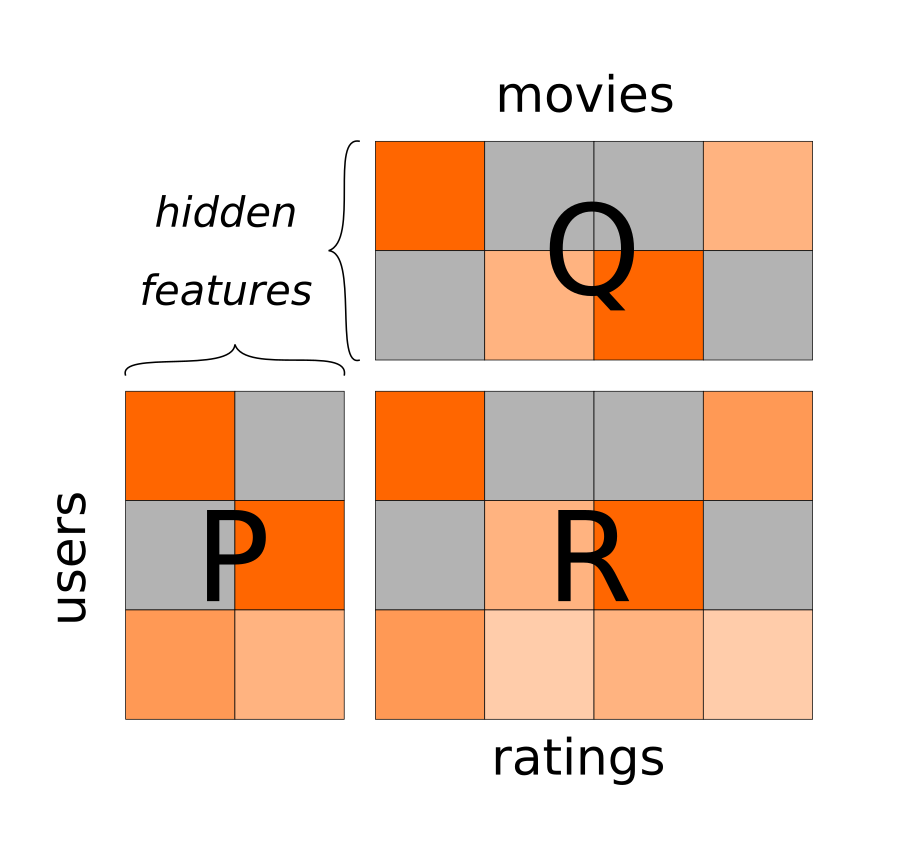

## In `sklearn`

### Read movie ratings in

In [1]:
import numpy as np
from sklearn.decomposition import NMF
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns


import src.utils as su

In [2]:
movies = pd.read_csv('../00_data/ml-latest-small/movies.csv', index_col='movieId')
movies

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


<AxesSubplot:>

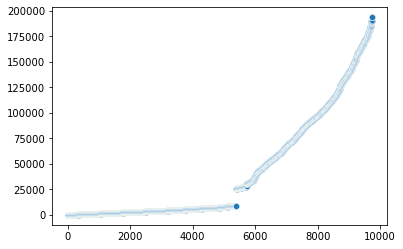

In [3]:
sns.scatterplot(x = range(len(movies)), y = movies.index.values)

In [4]:
su.get_movie(id=193583, movie_df=movies)

'No Game No Life: Zero (2017)'

In [9]:
ratings = su.prep_ratings("../00_data/nmf_ratings_matrix.json", 0)

### Create a model

Model assumes $R \sim PQ$ where $Q$ is a matrix that has every movie classified according to genres (components) and $P$ shows the user preferences for these components. 

`sklearn` has an `NMF` model that can create the components' matrices for both the users and the movies of the original data frame.

#### Step 1. Create a movie-genre matrix

We get get the matrix $Q$, which tells us how much each of the movies belongs to each of the 2 hidden features / genres, with `nmf.components_`.

In [10]:
nmf= NMF(n_components=20)

- Components (of hidden feutures, in our example 'genres'):
    - Small n_components = trains fast, might underfit
    - High n_components = trains slow, might overfit

In [11]:
# To calculate the Q
nmf.fit(ratings)

/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/home/alex/.conda/envs/spiced/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=20)

### Save a model

In [30]:
import pickle

binary = pickle.dumps(nmf)
open('../00_models/nmf.bin', 'wb').write(binary)
# binary

156283

In [21]:
Q = nmf.components_
Q.shape

(2, 9724)

In [22]:
# To get matrices Q and P

Q = pd.DataFrame(nmf.components_, columns=ratings.columns, index=["Feature1" ,"Feature2"])
Q
# Q: model.components_
# P: model.transform(Ratings)

,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
Feature1,1.504310,0.672969,0.556816,0.042623,0.316469,1.011735,0.45847,0.075933,0.081544,1.041706,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Feature2,0.825524,0.582731,0.000000,0.000000,0.071518,0.334804,0.00000,0.022690,0.000000,0.315845,...,0.004074,0.003492,0.004657,0.004657,0.004074,0.004657,0.004074,0.004074,0.004074,0.013215


<AxesSubplot:>

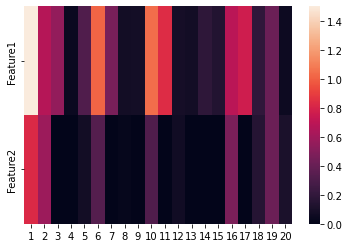

In [23]:
sns.heatmap(Q.iloc[:, 0:20], annot=False)

#### Create user-genre matrix 

See how the transform takes the samples (users) and transforms the  data for them as opposed to `model.components` that combines the features/columns (films) of the original df with newly created features.

When you think about the process remember the question: Which movie do I recommend to which user. Users are the rows in your df and you first need a model before creating the user-features matrix.

In [24]:
# .transform() to get P:
P = pd.DataFrame(nmf.transform(ratings), columns=["Feature1", "Feature2"], index=ratings.index)

In [25]:
P

,Feature1,Feature2
1,1.582375,0.088782
2,0.000000,0.271193
3,0.043601,0.000000
4,1.042928,0.000000
5,0.380515,0.000000
...,...,...
606,2.489033,1.005391
607,1.174707,0.000000
608,1.880210,1.831021
609,0.245140,0.000000


<AxesSubplot:>

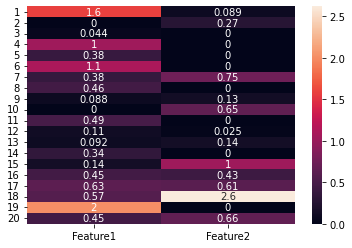

In [26]:
sns.heatmap(P.iloc[:20, :], annot=True)

The reconstructed error is a [measure](https://mathworld.wolfram.com/FrobeniusNorm.html) of the sum of the distances. We are trying to minimise this!

In [29]:
nmf.reconstruction_err_

1004.8718560369371

In [31]:

nmf = pickle.loads(binary)

In [32]:
nmf

NMF(n_components=2)

In [114]:
[print(type(i)) for i in [int(k) for k in {1:5, 2:0, 3:2.5}.values()]]

<class 'int'>
<class 'int'>
<class 'int'>


[None, None, None]

## Project Task: NMF recommender function

* Collect different user queries for "typical" users (e.g. a horror movie buff) and evaluate the algorithm
* Set the number of components to a very low number (e.g. 2). What happens to the recommendations?
* Implement a recommender function that recommends movies to a new user based on the NMF model!

In [98]:
ratings.iloc[0,:].shape
np.full()

(9724,)

In [175]:
all(x in movies.index.values for x in [2, 3])

True

In [176]:
def recommend_nmf(query, user_ratings, movies, model, k=10):
    """
    Filters and recommends the top k movies for any given input query based on a trained NMF model. 
    Returns a list of k movie ids.
    """

    # check if queried films exist
    movie_col_idxs = [int(k) for k in query.keys()]
    if not all(x in movies.index.values for x in movie_col_idxs):
        raise ValueError("movie doesn't exist")




    # 1. candiate generation
    # construct a user vector
    user_mat = user_ratings.copy()
    user_mat = user_mat.iloc[[0],:]
    user_mat.iloc[0,:] = 0

    user_mat.loc[:, movie_col_idxs] = [int(v) for v in query.values()]

    # print(user_mat.loc[:, movie_col_idxs])
    # print(user_mat.iloc[:,0:10 ])

      
    # 2. scoring
    # calculate the score with the NMF model
    user_scoring = model.transform(user_mat)
    
    # 3. ranking
    user_ranking = np.dot(user_scoring, nmf.components_)
    

    

    user_ranking = pd.DataFrame(data = user_ranking, columns = user_ratings.columns, index = ['user'])
    # set zero score to movies allready seen by the user
    user_ranking.loc[:, movie_col_idxs] = 0



    top_rankings = user_ranking.sort_values(by = 'user', axis = 1, ascending = False).iloc[[0], 0:k]

    # return the top-k highst rated movie ids or titles
    print(su.get_movie(id = top_rankings.columns, movie_df = movies))


    return top_rankings


In [180]:
# recommend_nmf(query = {1:5, 2:5, 3:2.5, 356: 4, 480: 2, 260:5, 12: 4, 300: 1},user_ratings=ratings, movies=movies, model = nmf, k = 5)

296                                   Pulp Fiction (1994)
593                      Silence of the Lambs, The (1991)
318                      Shawshank Redemption, The (1994)
1196    Star Wars: Episode V - The Empire Strikes Back...
589                     Terminator 2: Judgment Day (1991)
Name: title, dtype: object


,296,593,318,1196,589
user,0.175606,0.165011,0.156805,0.14829,0.142259


In [ ]:
recommend_nmf(
    query = {1:5, 2:5, 3:2.5, 356: 4, 480: 2, 260: 5, 12: 4, 300: 1},
    user_ratings=ratings,
    movies=movies,
    model = '../00_models/nmf.bin',
     k = 5)

In [179]:
pd.NA

<NA>